In [1]:
import sys
sys.path.insert(1, '../scripts/')


In [2]:
from data_loader import data_loader

load = data_loader()

In [3]:
load.df.head()

,name,album,artist,release_date,duration_ms,popularity,explicit,available_markets,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,genre
0,Overture / The Movement Revisited,The Movement Revisited: A Musical Portrait of ...,Christian McBride,2020-02-07,643564,17,False,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",0.494,0.810,0.500,0.00221,0.1090,-8.835,0.0838,139.080,4,Jazz
1,Pace,Pace,Nubya Garcia,2020-05-28,472733,38,False,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",0.366,0.123,0.631,0.44400,0.1200,-10.139,0.0586,147.200,1,Jazz
2,Sister Rosa,The Movement Revisited: A Musical Portrait of ...,Christian McBride,2020-02-07,385137,25,False,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",0.446,0.759,0.468,0.08630,0.1300,-11.041,0.0343,126.694,4,Jazz
3,WHITE CRAYON,Athletic Progression,Athletic Progression,2020-04-03,271250,56,False,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",0.417,0.148,0.450,0.88900,0.0869,-12.490,0.0443,81.234,4,Jazz
4,Sun Khosi,Sun Khosi,Ruby Rushton,2020-05-22,236886,42,False,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",0.523,0.601,0.510,0.79100,0.0771,-10.511,0.0673,108.886,3,Jazz


In [4]:
X_train, X_test, Y_train, Y_test = load.X_train, load.X_test, load.Y_train, load.Y_test

In [5]:
load.X.head()

,popularity,danceability,acousticness,energy
0,0.173469,0.508230,0.813253,0.500648
1,0.387755,0.376543,0.123492,0.632004
2,0.255102,0.458848,0.762048,0.468561
3,0.571429,0.429012,0.148593,0.450513
4,0.428571,0.538066,0.603413,0.510675


In [6]:
genre = (load.Y['genre'].unique())
genre.sort()

In [7]:
print(X_train.shape, Y_train.shape)

(1377, 4) (1377,)


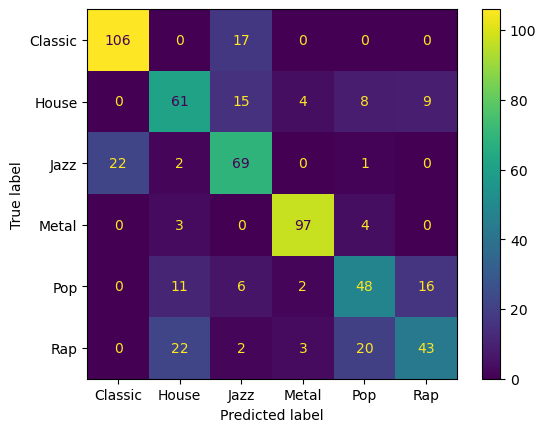

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svc = SVC(kernel="linear",probability=True)
svc.fit(X_train, Y_train) 

y_proba =svc.predict_proba(X_test)
y_pred  =svc.predict(X_test)

m = confusion_matrix(Y_test,y_pred,labels=genre)


cm_display = ConfusionMatrixDisplay(confusion_matrix = m,display_labels=genre)
cm_display.plot()
plt.show() 


In [9]:
train_score_c4 = svc.score(X_train, Y_train)
test_score_c4 = svc.score(X_test, Y_test)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

importances = svc.coef_[0]


Classical SVC on the training dataset: 0.74
Classical SVC on the test dataset:     0.72


<Axes: >

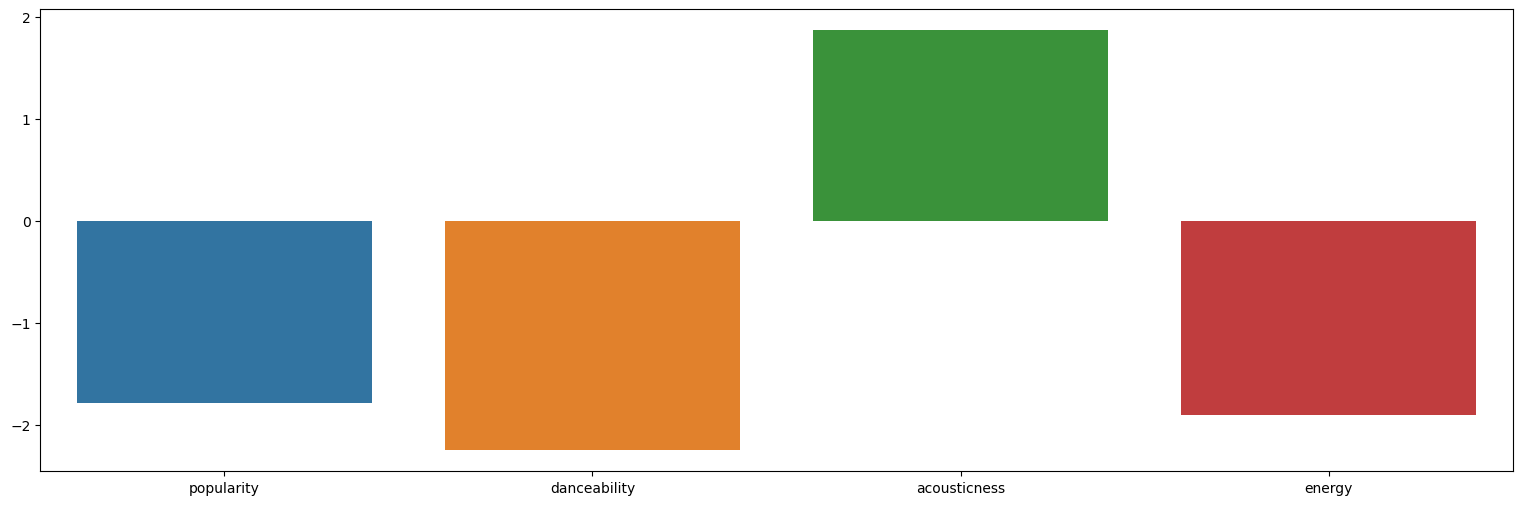

In [10]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (19, 6)


sns.barplot(x=list(load.X.columns),y=importances)


In [11]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", fold=20)



/usr/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


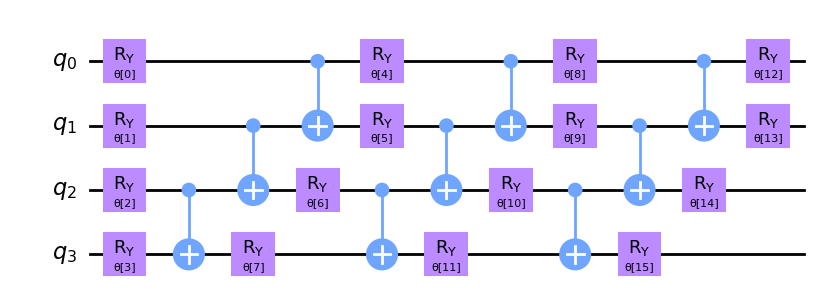

In [12]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)


In [13]:
list(load.X.columns)

['popularity', 'danceability', 'acousticness', 'energy']

In [14]:
Y_train

array(['Metal', 'House', 'Metal', ..., 'Jazz', 'House', 'Rap'],
      dtype=object)

In [15]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [16]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [17]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()



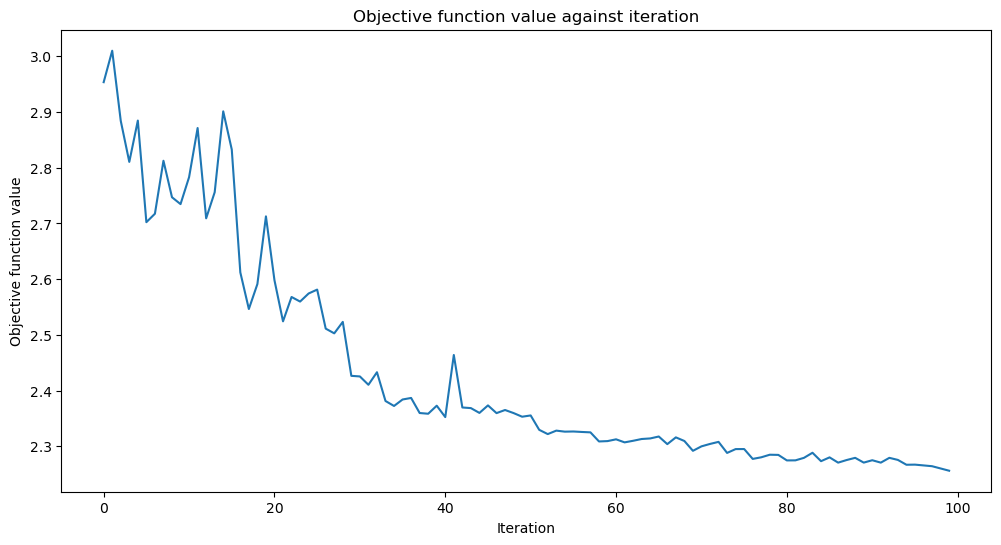

Training time: 496 seconds


In [18]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [19]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.39
Quantum VQC on the test dataset:     0.39


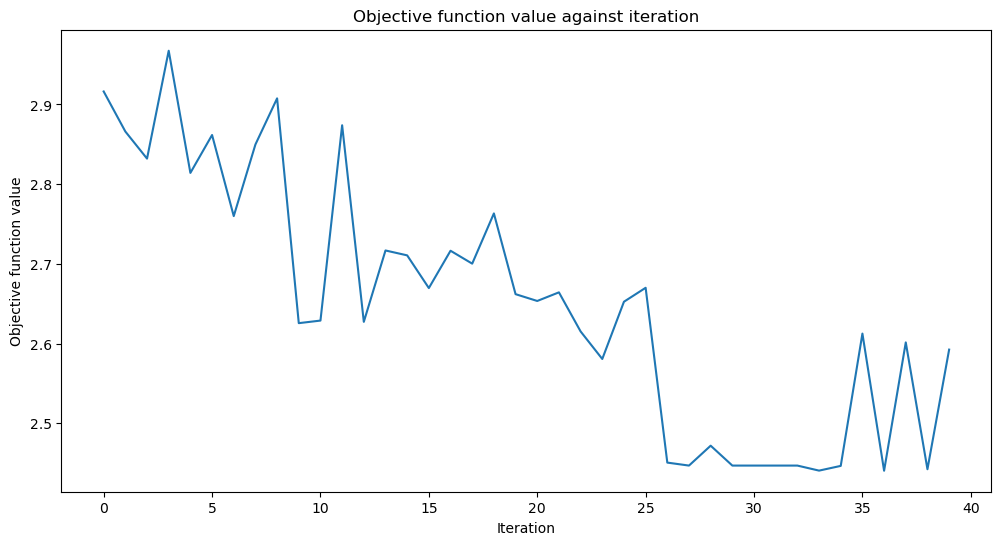

Training time: 273 seconds


In [20]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=load.X.shape[1], reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [21]:
train_score_q2_eff = vqc.score(X_train, Y_train)
test_score_q2_eff = vqc.score(X_test, Y_test)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.33
Quantum VQC on the test dataset using EfficientSU2:     0.32


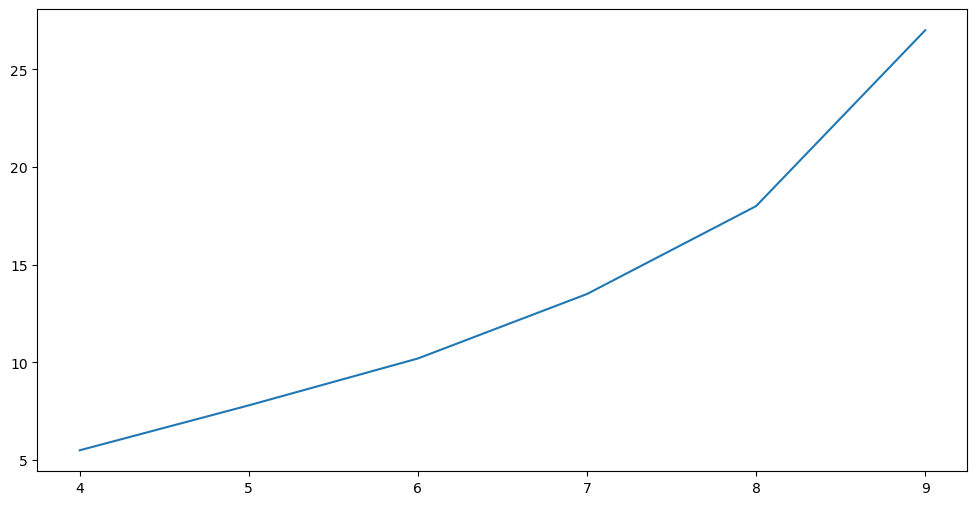

In [23]:
x = [4,5,6,7,8,9]
y=[5.5,7.8,10.2,13.5,18.0,27.0]
plt.plot( x , y  )



In [24]:
import numpy as np

def func(x, a, b, c):
    return a * np.exp(-b/1000 * x) + c


In [25]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, x, y)

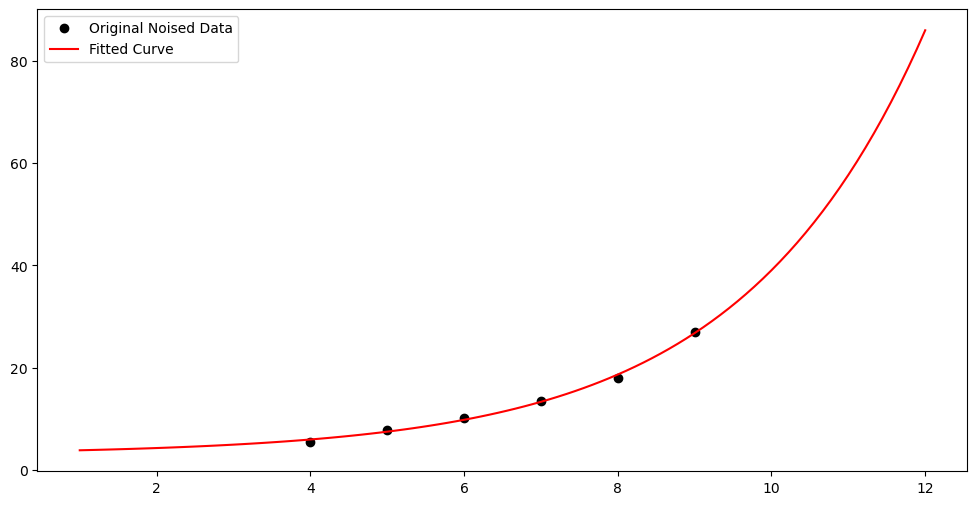

In [26]:
plt.figure()
plt.plot(x, y, 'ko', label="Original Noised Data")
plt.plot(np.linspace(1,12,100), func(np.linspace(1,12,100), *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()